In [2]:
#!jt -t solarizedd -T -N -kl     # Change theme 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf
import talib as ta
# import datetime as dt

In [4]:
sp = yf.download('^GSPC', start='2020-09-15', interval='60m')[4:]

sp = pd.DataFrame(data=sp)

sp.head()
sp.info()


close = sp['Adj Close'].values
OBV = ta.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
rsi = ta.RSI(close, timeperiod=14)





sp['OBV'] = ta.OBV(sp['Close'], sp['Volume'])

sp['OBV_EMA'] = ta.EMA(sp['OBV'], timeperiod=21)

sp


[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3362 entries, 2020-09-15 13:30:00-04:00 to 2022-08-12 16:00:00-04:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3362 non-null   float64
 1   High       3362 non-null   float64
 2   Low        3362 non-null   float64
 3   Close      3362 non-null   float64
 4   Adj Close  3362 non-null   float64
 5   Volume     3362 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 183.9 KB


,Open,High,Low,Close,Adj Close,Volume,OBV,OBV_EMA
Datetime,,,,,,,,
2020-09-15 13:30:00-04:00,3413.939941,3415.429932,3403.149902,3407.139893,3407.139893,220897990,2.208980e+08,NaN
2020-09-15 14:30:00-04:00,3407.139893,3408.820068,3394.959961,3398.909912,3398.909912,286143531,-6.524554e+07,NaN
2020-09-15 15:30:00-04:00,3398.780029,3403.040039,3389.250000,3400.830078,3400.830078,377551418,3.123059e+08,NaN
2020-09-16 09:30:00-04:00,3411.229980,3416.649902,3405.760010,3409.719971,3409.719971,0,3.123059e+08,NaN
2020-09-16 10:30:00-04:00,3409.790039,3421.659912,3402.239990,3420.300049,3420.300049,355890598,6.681965e+08,NaN
...,...,...,...,...,...,...,...,...
2022-08-12 12:30:00-04:00,4250.750000,4254.859863,4249.109863,4254.060059,4254.060059,142371926,6.186315e+09,5.999268e+09
2022-08-12 13:30:00-04:00,4254.069824,4260.330078,4253.439941,4260.250000,4260.250000,149731066,6.336046e+09,6.029885e+09
2022-08-12 14:30:00-04:00,4260.220215,4273.540039,4260.169922,4271.810059,4271.810059,206682000,6.542728e+09,6.076507e+09


In [5]:
#######Backtrader
 

import backtrader as bt
#import datetime
from backtrader.feeds import GenericCSVData



sp.index = sp.index.strftime("%Y-%m-%d %H:%M:%S")
sp


###
sp.to_csv('sp.csv')

    


btdata = GenericCSVData(dataname='sp.csv',
                     dtformat=('%Y-%m-%d %H:%M:%S'),
                     tmformat=('%H:%M:%S'),
                     datetime=0,
                     time=-1,
                     high=2,
                     low=3,
                     open=1,
                     close=4,
                     adjclose=5,
                     volume=6
                     #openinterest=-1,
                     #fromdate=date(2021, 2, 16),
                     #todate=date(2021, 2, 16)
                    )






#Create Buy and Sell Signal Observers

class BuySellSignal(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='$\u21E7$', markersize=12.0),
        sell=dict(marker='$\u21E9$', markersize=12.0)
    )






# Create a Trading Strategy

class SmaCross(bt.Strategy):
    alias = ('SMA_CrossOver',)
    
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=21   # period for the slow moving average
    )
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))  

    def __init__(self):
        self.flag = -1 #A flag for the trend upward/downward
        #sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        OBV = bt.talib.OBV(self.data.close, self.data.volume)
        #sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        EOBV = bt.talib.EMA(OBV, timeperiod=self.p.pslow)
        self.crossover = bt.ind.CrossOver(EOBV, OBV, plot=True)  # crossover signal
        self.log(f'Initial portfolio value of {self.broker.get_value():.2f}\n')
        

    def next(self):
        
    
        #if OBV > OBV_EMA  and flag != 1 then buy else sell
        if self.crossover > 0 and self.flag != 1 and not self.position:
              self.buy()  # enter long
              self.log(f'BUY {self.getsizing()} shares of {self.data._name} at {self.data.close[0]}')
              self.flag = 1
              
         #else  if OBV < OBV_EMA  and flag != 0 then sell else buy
        elif self.crossover > 0 and self.flag != 0:
            
            self.sell() #exit long
            self.log(f'CLOSE LONG position of {self.position.size} shares '
                       f'of {self.data._name} at {self.data.close[0]:.2f}')
            self.flag = 0     
          
        
        
        
        
        # if not self.position:  # not in the market
        #     if self.crossover > 0:  # if fast crosses slow to the upside
        #         self.buy()  # enter long
        #         self.log(f'BUY {self.getsizing()} shares of {self.data._name} at {self.data.close[0]}')

        # elif self.crossover < 0:  # in the market & cross to the downside
        #     self.sell() #exit long
        #     self.log(f'CLOSE LONG position of {self.position.size} shares '
        #                  f'of {self.data._name} at {self.data.close[0]:.2f}')



2022-08-12, Initial portfolio value of 300000.00

2020-09-22, BUY 20 shares of sp at 3283.570068359375
2020-09-23, CLOSE LONG position of 20 shares of sp at 3261.05
2020-09-24, BUY 20 shares of sp at 3257.320068359375
2020-09-28, CLOSE LONG position of 20 shares of sp at 3348.68
2020-09-29, BUY 20 shares of sp at 3339.77001953125
2020-09-30, CLOSE LONG position of 20 shares of sp at 3377.13
2020-10-01, BUY 20 shares of sp at 3379.110107421875
2020-10-02, CLOSE LONG position of 20 shares of sp at 3360.40
2020-10-07, BUY 20 shares of sp at 3418.43994140625
2020-10-13, CLOSE LONG position of 20 shares of sp at 3520.15
2020-10-15, BUY 20 shares of sp at 3483.219970703125
2020-10-16, CLOSE LONG position of 20 shares of sp at 3497.17
2020-10-22, BUY 20 shares of sp at 3453.590087890625
2020-10-26, CLOSE LONG position of 20 shares of sp at 3395.09
2020-10-27, BUY 20 shares of sp at 3390.669921875
2020-10-28, CLOSE LONG position of 20 shares of sp at 3272.28
2020-10-29, BUY 20 shares of sp at 

<IPython.core.display.Javascript object>


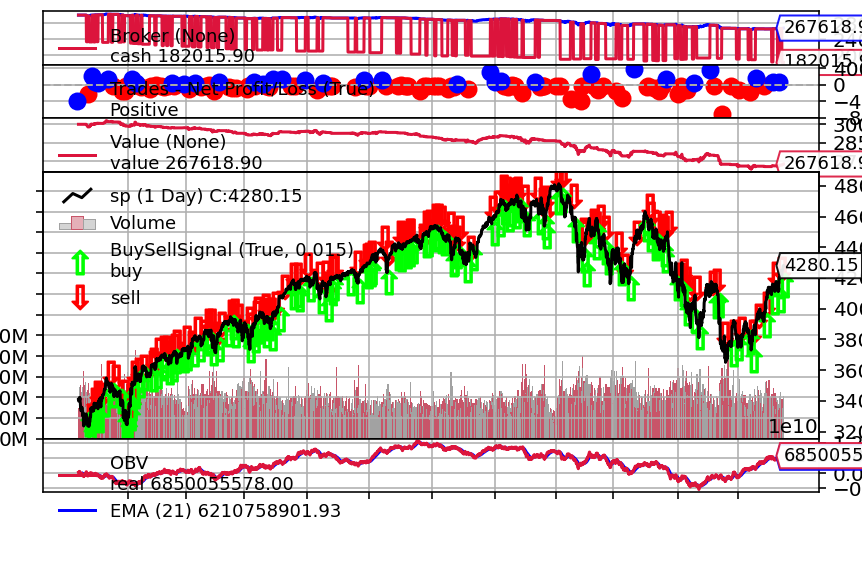

267618.9002246092

In [6]:




# Create cerebro Engine
cerebro = bt.Cerebro()

# Set Fixed Position Sizing
cerebro.addsizer(bt.sizers.SizerFix, stake=20)  

#Add datafeed to Cerebro Engine
cerebro.adddata(btdata)


# Set Initial Trading Capital and Trading Commissions
cerebro.broker.setcash(300000.0)
cerebro.broker.setcommission(commission=0.002)

#Add Trading Strategy to Cerebro
cerebro.addstrategy(SmaCross)

#Add Buy Sell Signals Observer to Cerebro
cerebro.addobserver(bt.observers.Value)

# Add Trading Statistics Analyzer
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

bt.observers.BuySell = BuySellSignal



#Run Cerebro Engine

start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

import matplotlib.pyplot as plt 

#Plot the Line Chart with Buy or Sell Signals
cerebro.plot()
plt.show()




#use now data to predict price in one hour 

#Create traning dataframe with prices shifted one period

#Create new columns with buy/sell signals

#Train data to preddict future price

#Could also predict with ta.timeseries

In [8]:

end_portfolio_value = cerebro.broker.getvalue()
pnl = end_portfolio_value - start_portfolio_value

pnl
#end_portfolio_value

-32381.099775390816